In [5]:
import numpy as np
import scipy.ndimage
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [269]:
def cv2_clipped_zoom(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

In [474]:
home = os.getcwd().split('AUT-CNN-TUB')[0]
canon_path  = os.path.join(home,'AUT-CNN-TUB/Data/AllParts/canon')
industy_path  = os.path.join(home,'/home/jeronimo/git/AUT-CNN-TUB/Data/AllParts/industry')
mixed_path  = os.path.join(home,'AUT-CNN-TUB/Data/AllParts')


In [271]:
len(os.listdir(os.path.join(home,industy_path)))

1126

In [477]:
img_name = os.listdir(os.path.join(home,industy_path))[11]
file_path = os.path.join(home,industy_path, img_name)
image = cv2.imread(file_path)

In [478]:
kernel_faktor = int(image.shape[1] * (0.018) -8)
kernel_faktor

15

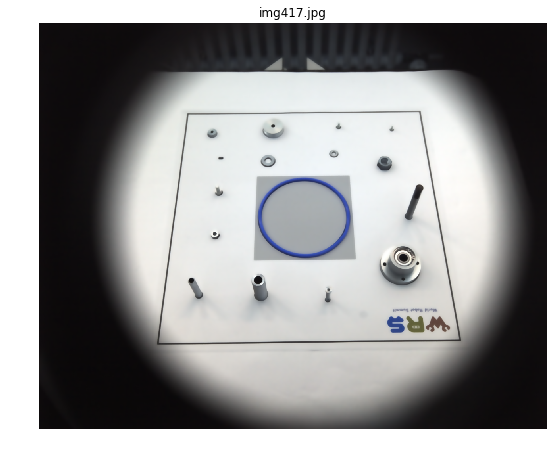

In [479]:
blurred = cv2.bilateralFilter(image,10, 80, 80)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(blurred)
plt.show()

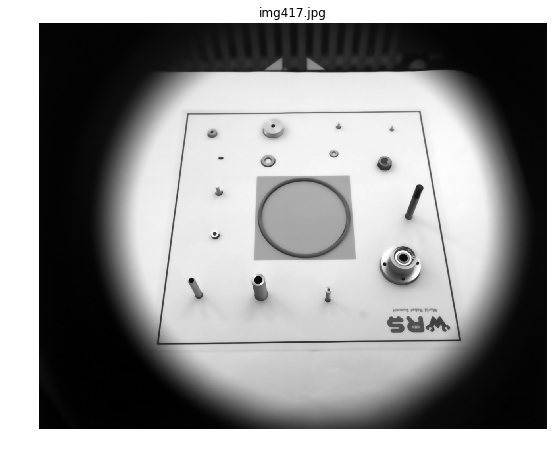

In [480]:
imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(imgray , cmap='gray')
plt.show()

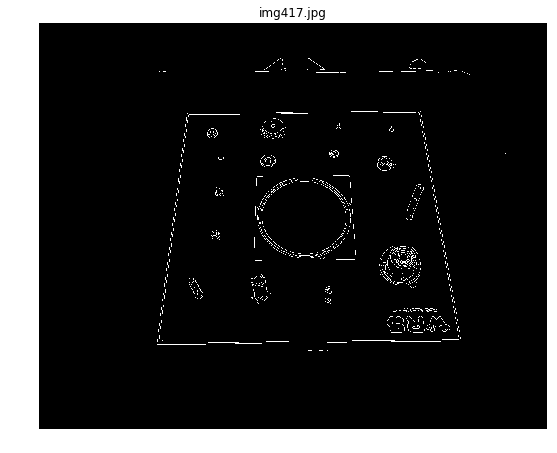

In [483]:
thresh = cv2.Canny(imgray,brightness,brightness)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(thresh, cmap='gray')
plt.show()

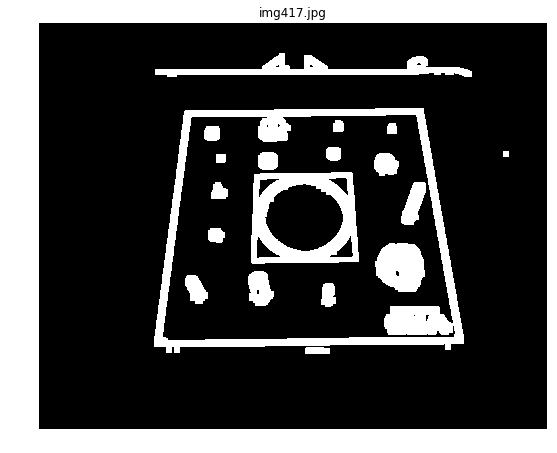

In [484]:
kernel = np.ones((kernel_faktor,kernel_faktor),np.uint8)
dilation = cv2.dilate(thresh,kernel,iterations = 1)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(dilation, cmap='gray')
plt.show()

In [485]:
h, b = dilation.shape

h*.6,b*.6

(614.4, 768.0)

In [486]:
h, b = thresh.shape
faktor = 0.5

_,contours,_ = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(blurred.shape,np.uint8)
sub_contour = [] 
for c in contours:
    if ((
        c[:,:,0].max()-c[:,:,0].min()) > b * faktor and (
        c[:,:,1].max()-c[:,:,1].min()) > h * faktor):
        
        print(len(c))    
        sub_contour.append(c)

area = (cv2.drawContours(mask, sub_contour, 0, (1,1,1), -1))

410
539


In [487]:
len(sub_contour[0])

410

In [488]:
area_new = cv2_clipped_zoom(area,0.94 )

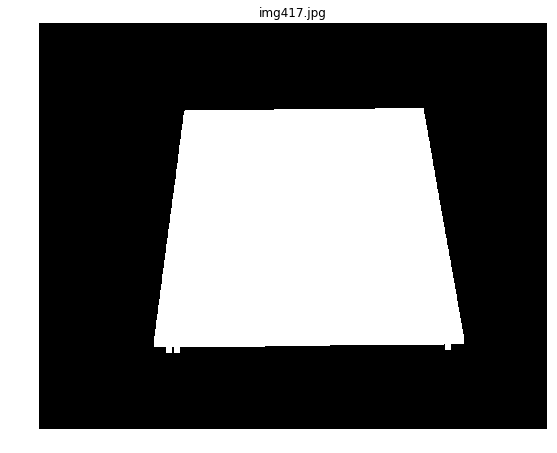

In [489]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(area[:,:,0],  cmap='gray')
plt.show()

In [490]:
area[:,:,0].sum()

415248

In [496]:
brightness = (imgray*area_new).mean()/kernel_faktor

ValueError: operands could not be broadcast together with shapes (1024,1280) (1024,1280,3) 

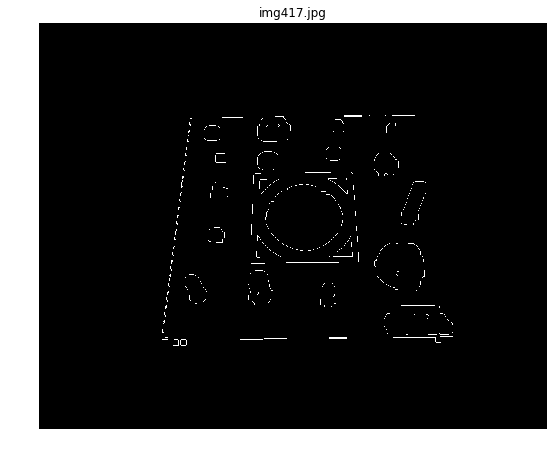

In [491]:
thresh2 = cv2.Canny(dilation*area_new[:,:,0],1,1)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(thresh2, cmap='gray')
plt.show()

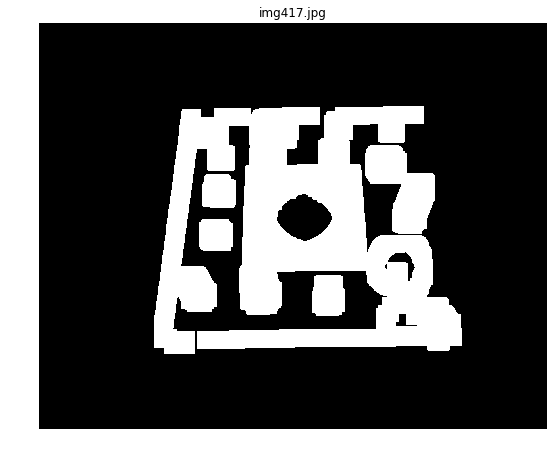

In [492]:
kernel = np.ones((kernel_faktor,kernel_faktor),np.uint8)
dilation = cv2.dilate(thresh2,kernel,iterations = 3)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(dilation, cmap='gray')
plt.show()

In [440]:

sub_contour = []
_,contours,_ = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    if len(c) < 800:
        if len(c) > 5:
            #if ((c[:,:,0].max()-c[:,:,0].min()) < 300 and (c[:,:,1].max()-c[:,:,1].min()) < 300):
     #       print(len(c)    
            sub_contour.append(c)

center = []
counter = 0
for c in sub_contour:
    counter += 1
    # compute the center of the contour
    M = cv2.moments(c)
    try:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        center.append([cx , cy ])
    except:
        print('moment is zero')
        
# find near center
center = np.array(center)
counter = 0
candidats = []
for i in center:
    counter += 1

    for e,s in enumerate(np.abs(center - i)):
        dist = np.linalg.norm(s)
        if (dist < 50 and dist !=0) == True:
            candidats.append(e)
            
to_drop = []
for e,c in enumerate(sub_contour):
    for n,test in enumerate(sub_contour):
        if n!= e:
            if c[:,:,0].max() < test[:,:,0].max():
                if c[:,:,0].min()  >  test[:,:,0].min():
                    if c[:,:,1].min() > test[:,:,1].min():
                        if c[:,:,1].max() < test[:,:,1].max():
                            to_drop.append(e)

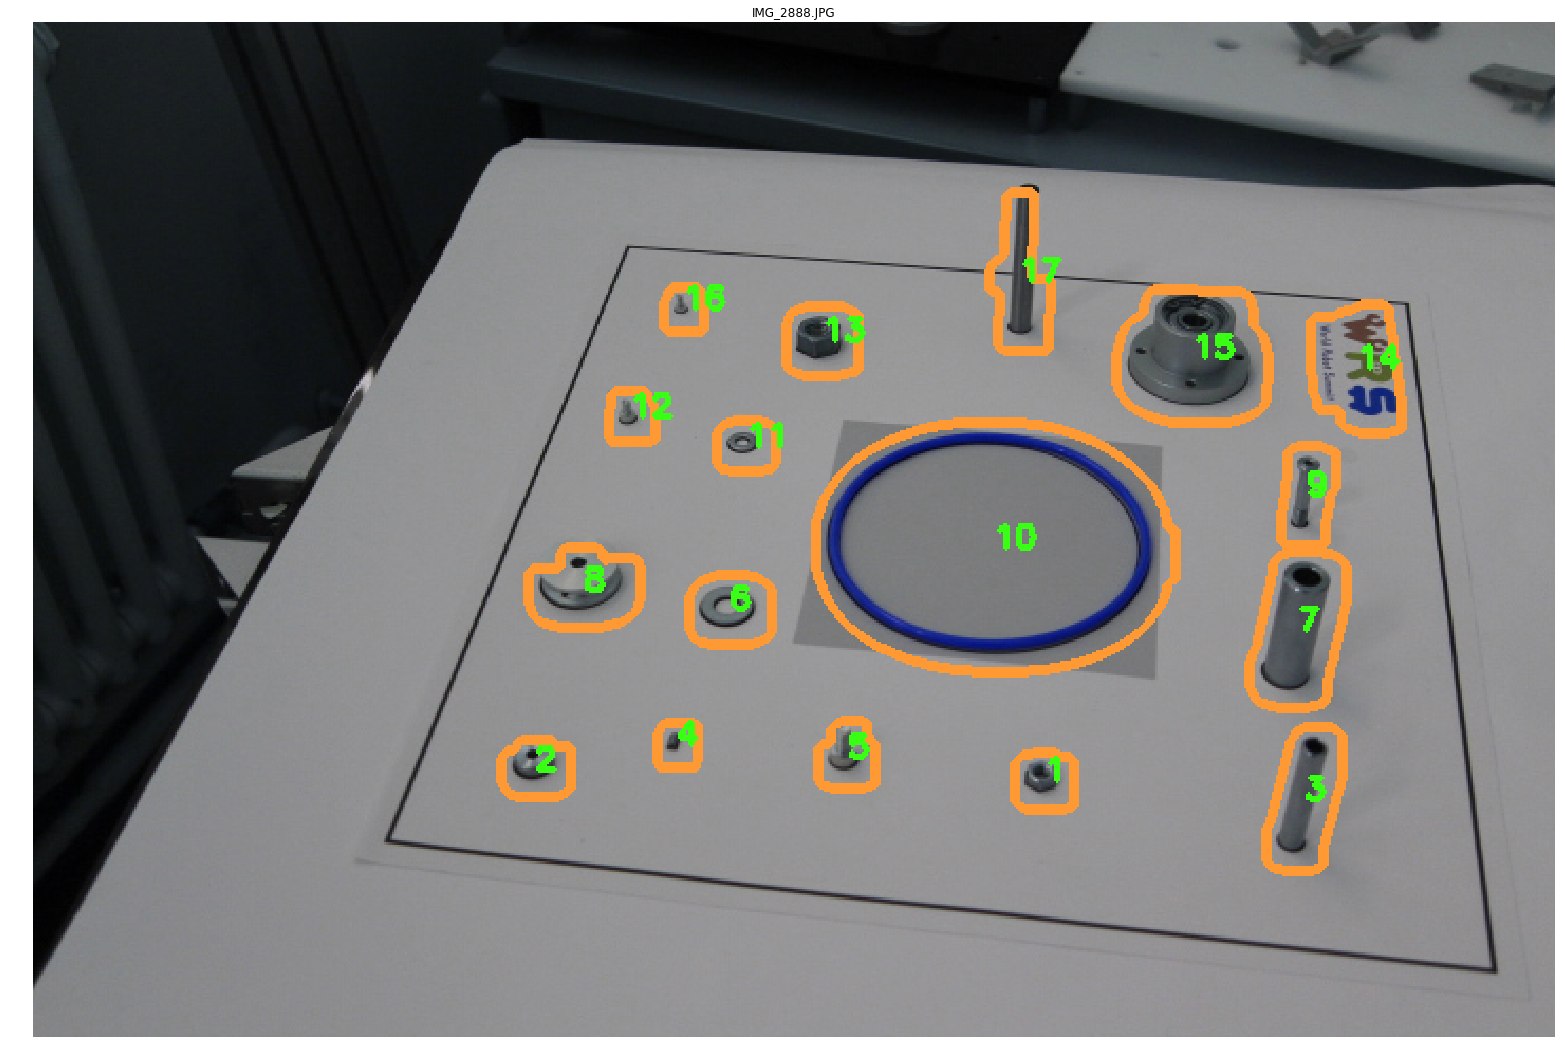

In [441]:
sub_con = np.delete(sub_contour, to_drop)
center = np.delete(center,to_drop,0)

img = cv2.drawContours(image, sub_con.tolist(), -3, (255, 153, 51), 3)

for e,ce in enumerate(center,1):
    cv2.putText(img, str(e), (ce[0] , ce[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (57, 255,20), 2)

fig = plt.figure(figsize=(60,60))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img, cmap='gray');

In [442]:
np.mean(thresh.shape)**2/ np.mean(thresh.shape)

600.0

In [443]:
np.mean(thresh.shape)/100 #23

6.0

In [542]:
12/(area.sum()/ (thresh.shape[0] * thresh.shape[1]))

32.339868057829975

In [470]:
canon_path

'/home/jeronimo/git/AUT-CNN-TUB/Data/AllParts'

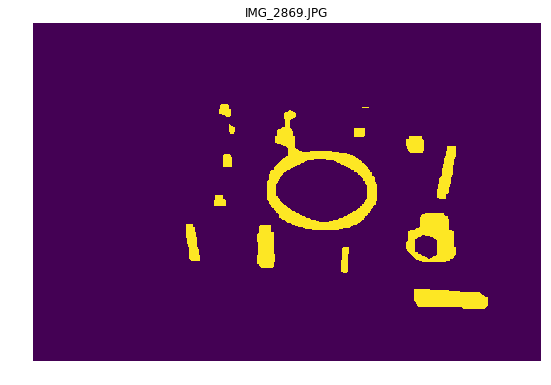

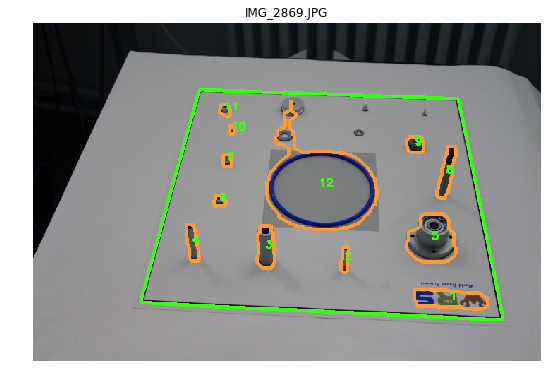

IMG_2869.JPG


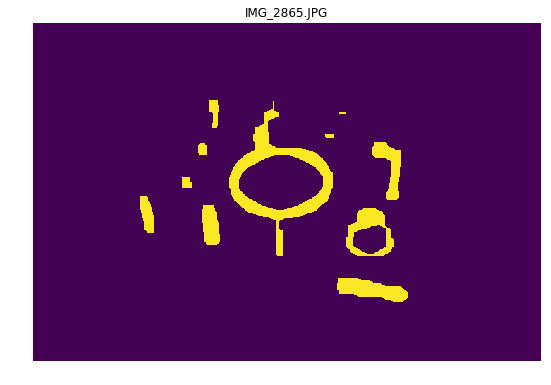

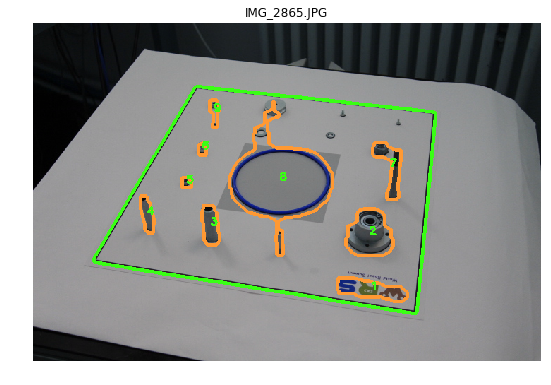

IMG_2865.JPG


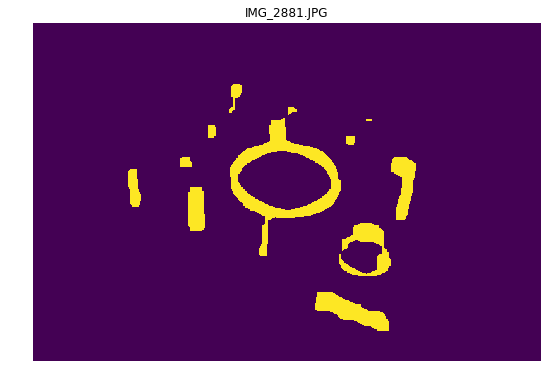

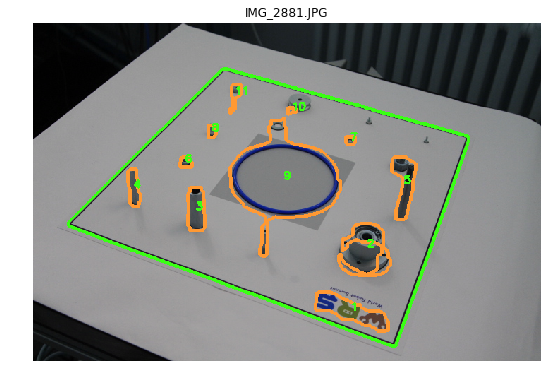

IMG_2881.JPG


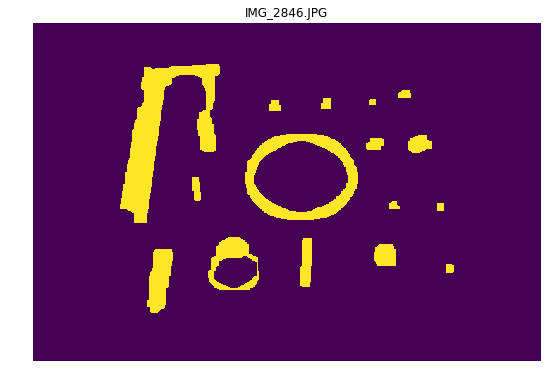

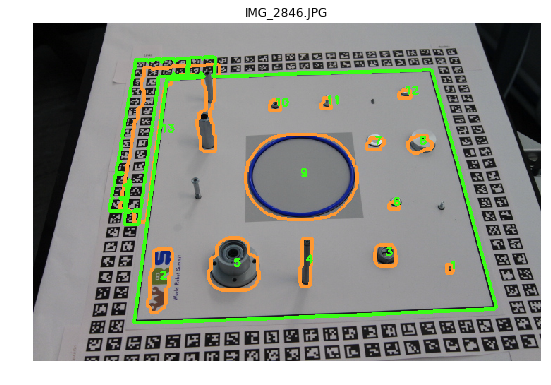

IMG_2846.JPG


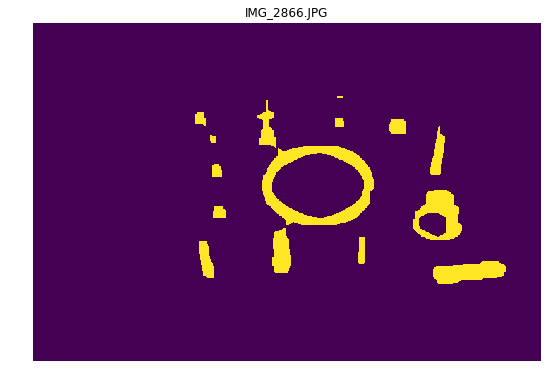

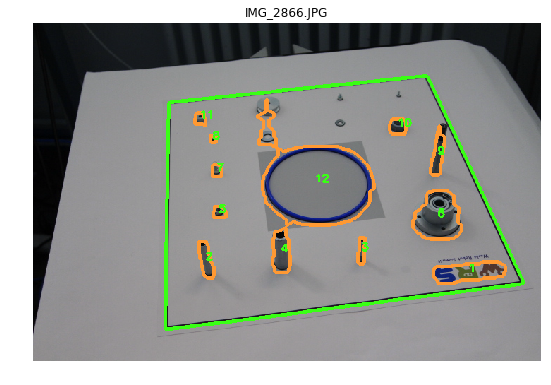

IMG_2866.JPG


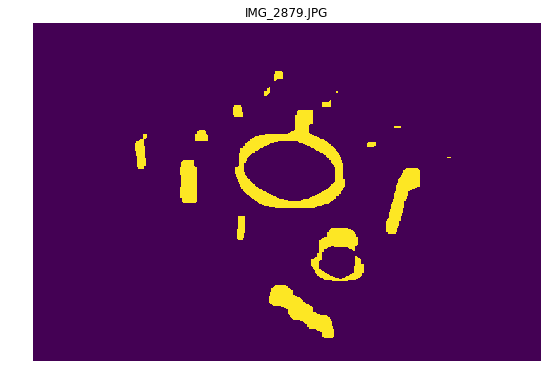

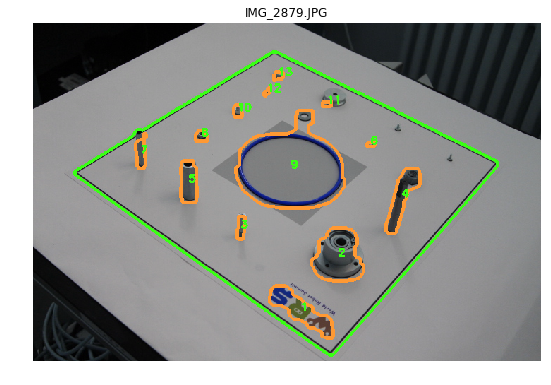

IMG_2879.JPG


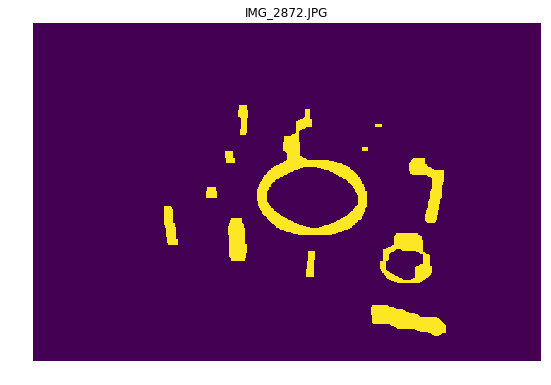

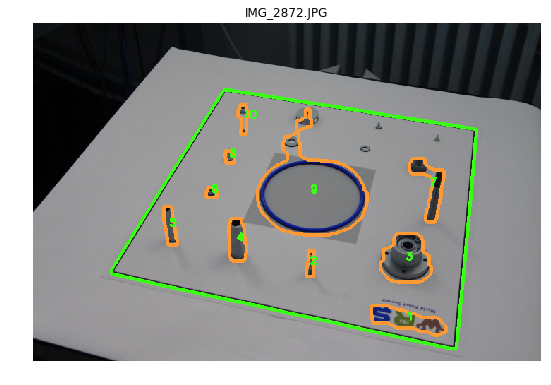

IMG_2872.JPG


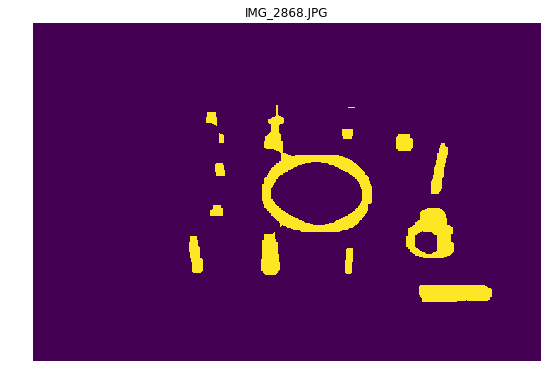

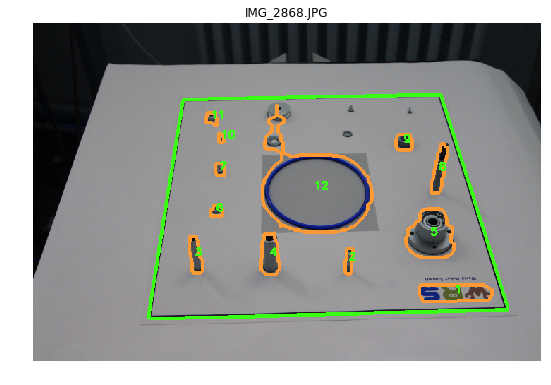

IMG_2868.JPG


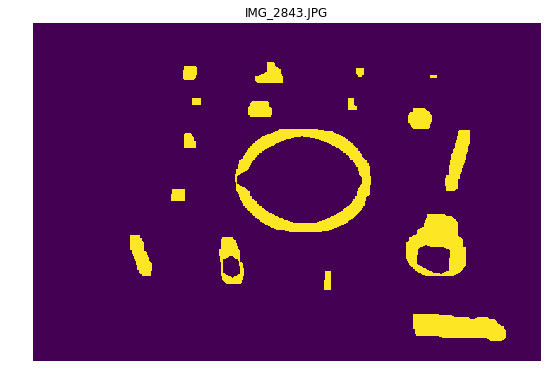

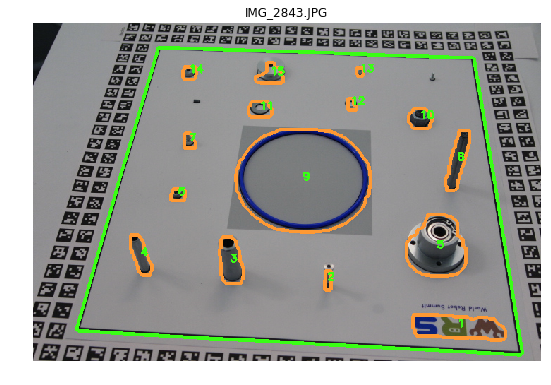

IMG_2843.JPG


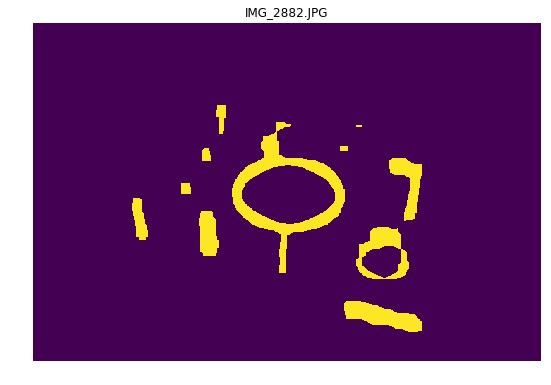

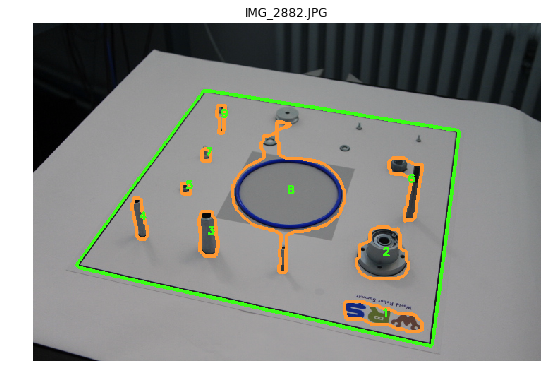

IMG_2882.JPG


In [473]:
path = canon_path # industy_path,  canon_path
for image_path in os.listdir(os.path.join(home,path))[:10]:
    
    img_name = image_path
    file_path = os.path.join(home,path, img_name)
    image = cv2.imread(file_path)
    
    kernel_faktor = int(image.shape[1] * (0.018) -8)

    blurred = cv2.bilateralFilter(image,10, kernel_faktor*10, kernel_faktor*10)
    imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)
    
    brightness = imgray.mean()/kernel_faktor*4
    
    thresh = cv2.Canny(imgray,brightness,brightness)
    
    kernel = np.ones((kernel_faktor,kernel_faktor),np.uint8)
    dilation = cv2.dilate(thresh,kernel,iterations = 1)
    
    form_factor = area.sum()/ (thresh.shape[0] * thresh.shape[1])

    h, b = thresh.shape
    faktor = 0.5

    _,contours,_ = cv2.findContours(dilation,
                                    cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(imgray.shape,np.uint8)
    sub_contour = [] 
    for c in contours:
        if ((
            c[:,:,0].max()-c[:,:,0].min()) > b * faktor and (
            c[:,:,1].max()-c[:,:,1].min()) > h * faktor):

            #print(len(c))    
            sub_contour.append(c)

    area = (cv2.drawContours(mask, sub_contour, 0, (1,1,1), -1))
    area_new = cv2_clipped_zoom(area,0.94)
    frame = sub_contour
    
    if area.sum() < 5000:
        print(img_name + ' bad image, no frame detected')
    else:
        blurred = cv2.bilateralFilter(imgray,10, 1000, 1000)
        thresh2 = cv2.Canny(blurred,70,70)#rightness+150,brightness+150)
      
        kernel_d = np.ones((3,3),np.uint8)
        dilation = cv2.dilate(thresh2*area_new, kernel_d, iterations = 10)
        
        kernel_e =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        erosion = cv2.erode(dilation, kernel_e, iterations = 5)

        
        fig = plt.figure(figsize=(20,20))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.axis('off')
        ax1.set_title(file_path.split('/')[-1])
        ax1.imshow(erosion)
        

        sub_contour = []
        _,contours,_ = cv2.findContours(erosion,cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            if len(c) < 800:
                if len(c) > 5:
                    if ((c[:,:,0].max()-c[:,:,0].min()) < 300 and
                        (c[:,:,1].max()-c[:,:,1].min()) < 300):
             #       print(len(c)    
                        sub_contour.append(c)

        center = []
        counter = 0
        for c in sub_contour:
            counter += 1
            # compute the center of the contour
            M = cv2.moments(c)
            try:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                center.append([cx , cy ])
            except:
                print('moment is zero')

        # find near center
        center = np.array(center)
        counter = 0
        candidats = []
        for i in center:
            counter += 1

            for e,s in enumerate(np.abs(center - i)):
                dist = np.linalg.norm(s)
                if (dist < 50 and dist !=0) == True:
                    candidats.append(e)

        to_drop = []
        for e,c in enumerate(sub_contour):
            for n,test in enumerate(sub_contour):
                if n!= e:
                    if c[:,:,0].max() < test[:,:,0].max():
                        if c[:,:,0].min()  >  test[:,:,0].min():
                            if c[:,:,1].min() > test[:,:,1].min():
                                if c[:,:,1].max() < test[:,:,1].max():
                                    to_drop.append(e)
        sub_con = np.delete(sub_contour, to_drop)
        center = np.delete(center,to_drop,0)

        img = cv2.drawContours(image, sub_con.tolist(), -3, (255, 153, 51), 3)

        for e,ce in enumerate(center,1):
            cv2.putText(img, str(e), (ce[0] , ce[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (57, 255,20), 2)
        
        cv2.drawContours(image, frame, 0, (57, 255,20), 3)

        fig = plt.figure(figsize=(20,20))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.axis('off')
        ax1.set_title(file_path.split('/')[-1])
        ax1.imshow(img, cmap='gray')
        plt.show()
        print(img_name)